# Raleigh FD stations report

In [1]:
%matplotlib inline

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from scipy import stats
import gmaps
import gmaps.datasets
from config import gkey
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Importing and cleaning data for reports on year, station
- API Calls were performed in FireDataAPI
- The main dataset and one that consistently failed in the loop (records 122000-123999) were merged into one in FireDatacsv.
- The merged dataset was cleaned of any nulls in 'incident type' code
- Importing that combined data for analysis

##### Importing the cleaned/combined data from the csv with the years 2008-2018

In [3]:
firefile = './output/all_with_no_incident_nulls.csv'
df = pd.read_csv(firefile, skip_blank_lines=True, encoding='UTF-8',low_memory=False)
len(df)

158423

##### Reformatting the dates to datetime 

In [4]:
df['arrive_date_time'] = pd.to_datetime(df['arrive_date_time'])
df['cleared_date_time'] = pd.to_datetime(df['cleared_date_time'])
df['dispatch_date_time'] = pd.to_datetime(df['dispatch_date_time'])
df.dtypes

GlobalID                             object
OBJECTID                              int64
address                              object
address2                             object
apt_room                             object
arrive_date_time             datetime64[ns]
cleared_date_time            datetime64[ns]
dispatch_date_time           datetime64[ns]
exposure                              int64
incident_number                      object
incident_type                       float64
incident_type_description            object
platoon                              object
station                             float64
Longitude                           float64
Latitude                            float64
Year                                  int64
Date                                 object
dtype: object

##### Getting rid of the decimal in the year column, an artifact of the export perhaps

In [5]:
df['Year'] = df['Year'].astype(float).map("{:.0f}".format)

##### The total number of rows with the years 2008-2018 and incident type not null

In [6]:
len(df.loc[df['incident_type'].notnull()])

158423

# Fire station analysis

##### Adding a column with the time from dispatch to cleared in seconds

In [7]:
arr_time = (df['arrive_date_time'] - df['dispatch_date_time'])
arr_time = pd.to_timedelta(arr_time)
df['Seconds'] = arr_time.dt.total_seconds()
df.head(2)

,GlobalID,OBJECTID,address,address2,apt_room,arrive_date_time,cleared_date_time,dispatch_date_time,exposure,incident_number,incident_type,incident_type_description,platoon,station,Longitude,Latitude,Year,Date,Seconds
0,eb6f5e12-dec5-4f55-9746-d2867a13d9e6,474769,"8332 SHILOH CREEK CT RALEIGH, NC 27603",NaN,,2013-10-19 21:52:00,2013-10-19 21:59:00,2013-10-19 21:47:00,0,13-0030918,150.0,Outside rubbish fire Other,B,22.0,-78.537320,35.891622,2013,2013-10-19,300.0
1,8df5e743-2b41-4b22-9012-6e8cbe9327e2,474770,"7513 IDOLBROOK LN RALEIGH, NC 27615",NaN,,2014-02-14 21:49:00,2014-02-14 21:51:00,2014-02-14 21:46:00,0,14-0004846,510.0,Person in distress Other,A,4.0,-78.647631,35.878186,2014,2014-02-14,180.0


In [8]:
# Getting rid of the 38 entries that have no station assigned
dfs = df.loc[df['station'].notnull()]

# Return the count of records scrubbed
len(df.loc[df['station'].isna()])

36

In [9]:
# Getting rid of the ugly decimal in the station number by converting to a string
pd.options.mode.chained_assignment = None
dfs['station'] = dfs['station'].astype(int)

## Station response time

### Removed records with no arrival time

In [10]:
# Getting rid of entries with no arrive time.
# These fell into six categories, none of which were measurable incidents
dfn = dfs.loc[dfs['arrive_date_time'].isna()]
no_time = dfn['incident_type_description'].unique()

for item in no_time:
    print(item)

Dispatched & cancelled en route
False alarm or false call Other
Cover assignment standby moveup
Alarm system sounded due to malfunction
Service Call other
Dispatched & cancelled en route                   


In [11]:
dfst = dfs.loc[dfs['arrive_date_time'].notnull()]
len(dfst)

128714

In [12]:
dfst = dfst.loc[dfst['station']!=13]

In [13]:
# There appear to be some funky clearance times, possibly human error
outliers = dfst[dfst['Seconds'] > dfst['Seconds'].mean() + 3 * dfst['Seconds'].std()]
no_outliers = dfst[dfst['Seconds'] <= dfst['Seconds'].mean() + 3 * dfst['Seconds'].std()]

In [14]:
len(outliers)

58

In [15]:
len(no_outliers)

128655

In [16]:
no_outliers['station'] = round(no_outliers['station'],0)
stations_sorted = no_outliers.sort_values('station')
stations_sorted.head()


,GlobalID,OBJECTID,address,address2,apt_room,arrive_date_time,cleared_date_time,dispatch_date_time,exposure,incident_number,incident_type,incident_type_description,platoon,station,Longitude,Latitude,Year,Date,Seconds
126856,955dca87-3b15-4930-869d-cf4dbbf2fb5b,620940,"120 S WILMINGTON ST RALEIGH, NC 27601",PARKING DECK ALEXANDER SQUARE,,2017-01-14 04:48:00,2017-01-14 04:55:00,2017-01-14 04:46:00,0,17-0001522,700.0,False alarm or false call Other,C,1,-78.638214,35.778893,2017,2017-01-14,120.0
15797,98041c4d-8fd2-405e-b5ba-baf1ced9289a,492895,"734 S PERSON ST RALEIGH, NC 27601",NaN,,2012-10-13 00:37:00,2012-10-13 00:47:00,2012-10-13 00:34:00,0,12-0029658,710.0,Malicious mischievous false call Other,A,1,-78.635323,35.771454,2012,2012-10-13,180.0
123595,158e80ce-e2cc-41e5-a7f2-67a2d3ab191f,617589,"317 W MORGAN ST RALEIGH, NC 27601",THE DAWSON BLDG,,2016-11-30 17:38:00,2016-11-30 18:18:00,2016-11-30 17:35:00,0,16-0038225,735.0,Alarm system sounded due to malfunction,B,1,-78.643964,35.779769,2016,2016-11-30,180.0
123588,526f9bb9-f853-4a19-bb33-9faa92855e6c,617581,"509 GLENWOOD AVE RALEIGH, NC 27601",GLENWOOD TOWERS,,2016-11-28 06:08:00,2016-11-28 06:36:00,2016-11-28 06:03:00,0,16-0037947,251.0,Excessive heat scorch burns with no ignition,A,1,-78.647256,35.786883,2016,2016-11-28,300.0
123580,01c0011b-56a2-41cd-a304-7ebac4401d72,617573,"116 ST MARYS ST RALEIGH, NC 27601",CARRIAGE HOUSE APTS,,2016-11-24 04:42:00,2016-11-24 04:55:00,2016-11-24 04:38:00,0,16-0037570,743.0,Smoke detector activation no fire - unintentional,A,1,-78.650615,35.781902,2016,2016-11-24,240.0


In [17]:
station_means = stations_sorted.groupby('station')['Seconds'].mean()


In [18]:
station_err = stations_sorted.groupby('station')['Seconds'].sem()


In [19]:
station_std = stations_sorted.groupby('station')['Seconds'].std()

In [20]:
overall_mean = round(dfst['Seconds'].mean())
overall_std = round(dfst['Seconds'].std())
overall_err = round(dfst['Seconds'].sem())

print(f'The RFD stations had a {overall_mean} second response time, with standard deviation {overall_std}, error {overall_err}')

The RFD stations had a 306 second response time, with standard deviation 1049, error 3.0


In [21]:
#Removing the outliers
overall_mean = round(no_outliers['Seconds'].mean(), 2)
overall_std = round(no_outliers['Seconds'].std(),2)

print(f'After removing outliers, the RFD stations had a {overall_mean} second response time, with standard deviation {overall_std}.')

After removing outliers, the RFD stations had a 292.07 second response time, with standard deviation 143.35.


In [22]:
slowest = round(station_means.max(), 2)
quickest = round(station_means.min(), 2)
print(f'The station with the fastest response times averaged {quickest} seconds while the slowest averaged {slowest}.')

The station with the fastest response times averaged 232.54 seconds while the slowest averaged 341.4.


In [23]:
slow_stations = []
count = 0
for item, key in station_means.iteritems():
    if (key - overall_mean) > 0:
        slow_stations.append(item)
        count += 1
print(f'There are {count} stations with response times above average: {slow_stations}')

There are 18 stations with response times above average: [2, 4, 6, 8, 11, 15, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


### Plot mean response time per station with errors

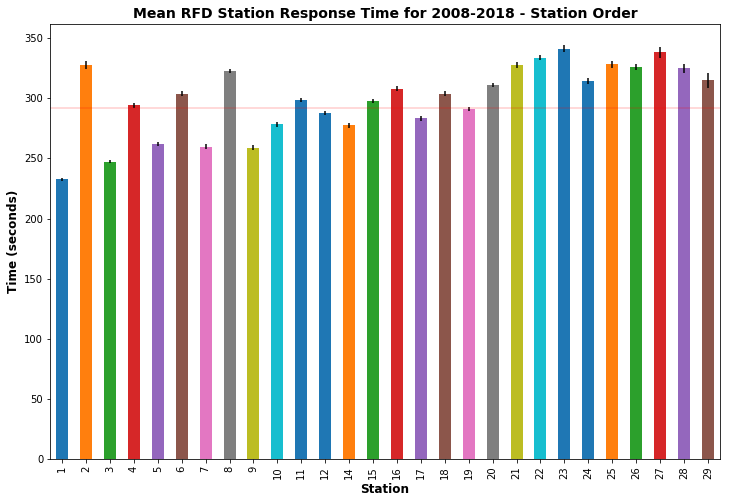

In [24]:
station_means.plot(yerr=station_err, kind='bar')
fig = plt.gcf()
fig.set_size_inches(12, 8)
fig.ylimit=(0,400)
fig.xlimit=(0,30)
plt.hlines(overall_mean, -1, 30, alpha=0.2, label='Overall mean', color='red')
# Add some labels and title
plt.xlabel('Station', fontsize=12, fontweight='bold')
plt.ylabel('Time (seconds)', fontsize=12, fontweight='bold')
plt.title('Mean RFD Station Response Time for 2008-2018 - Station Order', fontsize=14, fontweight='bold')
# Save the figure
plt.savefig('./graphics/station_response_time_summary.png')

##### Scatterplot of mean response time per station/year for further investigation

In [25]:
ss = stations_sorted.groupby(['Year','station'])['Seconds'].mean()
ssu = ss.unstack()
ssu

station,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
Year,,,,,,,,,,,,,,,,,,,,,
2008,231.216617,302.696629,225.457810,280.993789,264.051724,287.762376,254.292135,305.000000,224.385246,294.470990,...,313.856502,311.618497,295.704989,334.947368,313.450882,255.806452,317.109375,308.727273,298.560000,NaN
2009,209.079755,284.788732,206.729323,270.389610,255.479115,279.953271,239.200000,301.297297,229.702517,253.680782,...,304.255319,308.540146,289.618321,341.052632,302.093023,309.122807,305.576208,285.853659,290.000000,NaN
2010,219.252336,294.061433,231.102662,283.296703,253.615960,298.390244,245.276382,318.812616,237.241379,249.600000,...,314.078212,315.229358,327.750000,320.625000,318.475610,295.048544,334.447950,324.642857,303.296703,NaN
2011,226.113537,310.551181,254.512635,280.645161,256.817102,300.436893,248.356164,323.361921,263.187773,261.671159,...,303.851852,307.792208,343.318386,336.680162,307.735849,330.933333,318.461538,331.272727,315.510204,NaN
2012,243.597002,309.122807,260.300752,299.213115,274.087760,317.914110,261.760000,317.290076,262.119816,277.577855,...,308.189415,324.299065,351.255605,341.478261,327.563025,319.363636,320.395257,330.000000,320.547945,NaN
2013,248.023256,322.240000,254.149909,285.531915,264.000000,311.165919,281.277641,325.423729,260.160000,291.683168,...,307.752809,342.000000,350.757946,366.172840,316.302521,330.238095,311.811024,346.466165,310.866142,NaN
2014,239.213710,357.034884,250.952381,314.095238,266.543779,314.460888,286.595745,340.597540,264.738041,292.521246,...,317.010989,334.067797,333.396226,376.764706,345.806452,365.517241,337.793594,382.058824,333.698630,NaN
2015,236.096654,350.414201,247.694805,308.681672,262.139738,299.106700,253.920000,327.517986,290.000000,286.080000,...,315.375000,340.714286,333.717949,342.491803,337.173913,339.635036,324.403670,313.333333,335.857988,311.186441
2016,252.774869,350.731707,253.945946,305.981308,285.000000,300.864198,266.547315,338.611987,270.063694,302.131148,...,336.391555,348.645161,343.355705,360.000000,315.037594,347.547170,334.551724,366.162162,351.340206,321.951220


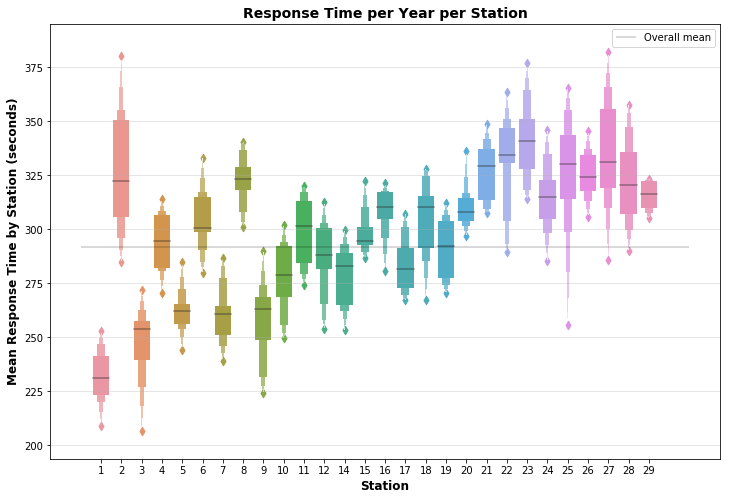

In [26]:
g = sns.boxenplot(data=ssu)
fig = plt.gcf()
fig.set_size_inches(12, 8)
fig.ylimit=(200,400)
fig.xlimit=(0,29)
plt.hlines(overall_mean, -1, 29, alpha=0.2, label='Overall mean')
plt.grid(alpha=0.4, axis='y')
plt.xlabel('Station', fontsize=12, fontweight='bold')
plt.ylabel('Mean Response Time by Station (seconds)', fontsize=12, fontweight='bold')
plt.title('Response Time per Year per Station', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.savefig('./graphics/station_response_time_boxen.png')

In [27]:
rfd = pd.read_csv('./output/raleigh_fire_stations.csv')
rfd

,X,Y,OBJECTID,ID,LABEL,LOCATION,CITY,AGENCY,STATIONID,RECNO
0,-78.643753,35.777620,1323,1,RFD #1,220 S. Dawson St,Raleigh,RF,S01,58
1,-78.647936,35.748519,1289,2,RFD #2,263 Pecan Rd,Raleigh,RF,S02,24
2,-78.632205,35.779491,1292,3,RFD #3,13 S. East St,Raleigh,RF,S03,27
3,-78.648385,35.882536,1315,4,RFD #4,121 Northway Ct,Raleigh,RF,S04,50
4,-78.661864,35.788267,1293,5,RFD #5,300 Oberlin Rd,Raleigh,RF,S05,28
5,-78.655741,35.809223,1294,6,RFD #6,2601 Fairview Rd,Raleigh,RF,S06,29
6,-78.612775,35.792728,1295,7,RFD #7,2100 Glascock St,Raleigh,RF,S07,30
7,-78.708671,35.786232,1287,8,RFD #8,5001 Western Blvd,Raleigh,RF,S08,22
8,-78.643112,35.841306,1314,9,RFD #9,4465 Six Forks Rd,Raleigh,RF,S09,49
9,-78.613156,35.741720,1291,10,RFD #10,2711 Sanderford Rd,Raleigh,RF,S10,26


In [28]:
station = rfd[['Y','X']]
label = [item for item in rfd['LABEL']]
label

['RFD #1',
 'RFD #2',
 'RFD #3',
 'RFD #4',
 'RFD #5',
 'RFD #6',
 'RFD #7',
 'RFD #8',
 'RFD #9',
 'RFD #10',
 'RFD #11',
 'RFD #12',
 'RFD #14',
 'RFD #15',
 'RFD #16',
 'RFD #17',
 'RFD #18',
 'RFD #19',
 'RFD #20',
 'RFD #21',
 'RFD #22',
 'RFD #23',
 'RFD #24',
 'RFD #25',
 'RFD #26',
 'RFD #27',
 'RFD #28',
 'RFD #29']

In [29]:
# Attempted using Gmaps to plot wind data, but there is a flare near Brazil that isn't reflected in the map, 
# think it is just close together datapoints
gmaps.configure(api_key=gkey)

# Center and zoom the map
coordinates = (35.7894263,-78.6388527)

figure_layout = {
    'width': '800px',
    'height': '500px',
    'border': '1px solid black',
    'padding': '1px'
}

fire_layer = gmaps.symbol_layer(station, fill_color='red', stroke_color='red', scale=3, hover_text=label)
fig = gmaps.figure(layout=figure_layout, center=coordinates, zoom_level=11)

fig.add_layer(fire_layer)
fig

Figure(layout=FigureLayout(border='1px solid black', height='500px', padding='1px', width='800px'))

### Station Response Time Summary
- There were 10 stations whose response times were above the mean response time: (2, 8, 21, 22, 23, 24, 25, 26, 27, 28)
- The response times are skewed to the right of the normal distribution
- The stations with slower response times are on the outskirts of the city.
- Do they cover a wider area than stations in town?

In [30]:
slow_df = df.loc[df['station'].isin(slow_stations)]


In [31]:
fast_stations = []
count = 0
for item, key in station_means.iteritems():
    if (key - overall_mean) <= 0:
        fast_stations.append(item)
        count += 1
fast_stations

[1, 3, 5, 7, 9, 10, 12, 14, 17, 19]

In [32]:
fast_df = df.loc[df['station'].isin(fast_stations)]

In [33]:
len(slow_df)

87127

In [34]:
len(fast_df)
fast_df.dtypes

GlobalID                             object
OBJECTID                              int64
address                              object
address2                             object
apt_room                             object
arrive_date_time             datetime64[ns]
cleared_date_time            datetime64[ns]
dispatch_date_time           datetime64[ns]
exposure                              int64
incident_number                      object
incident_type                       float64
incident_type_description            object
platoon                              object
station                             float64
Longitude                           float64
Latitude                            float64
Year                                 object
Date                                 object
Seconds                             float64
dtype: object

In [35]:
slow_df_no = slow_df.loc[slow_df['Longitude'].astype(int) > -80]

In [36]:
fast_df_no = fast_df.loc[fast_df['Longitude']> -80]

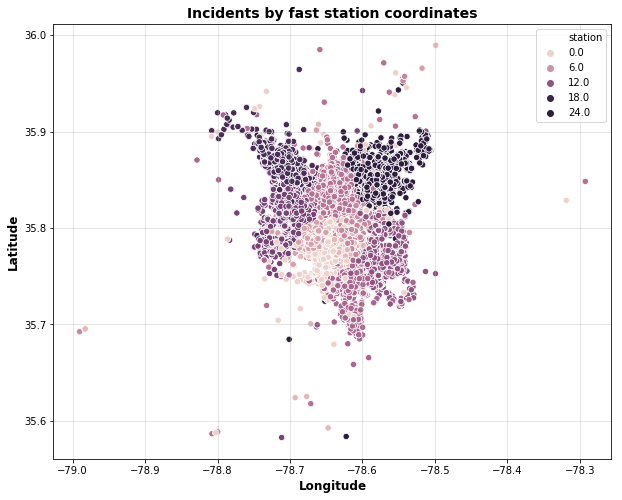

In [37]:
sns.scatterplot(data=fast_df_no, x='Longitude', y='Latitude', hue='station', legend='brief', s=40)
fig = plt.gcf()
fig.set_size_inches(10, 8)
fig.ylimit=(-60,45)
fig.xlimit=(-65,85)
plt.grid(alpha=0.4)
plt.xlabel('Longitude', fontsize=12, fontweight='bold')
plt.ylabel('Latitude', fontsize=12, fontweight='bold')
plt.title("Incidents by fast station coordinates", fontsize=14, fontweight='bold')
plt.savefig('./graphics/fast_station.png')

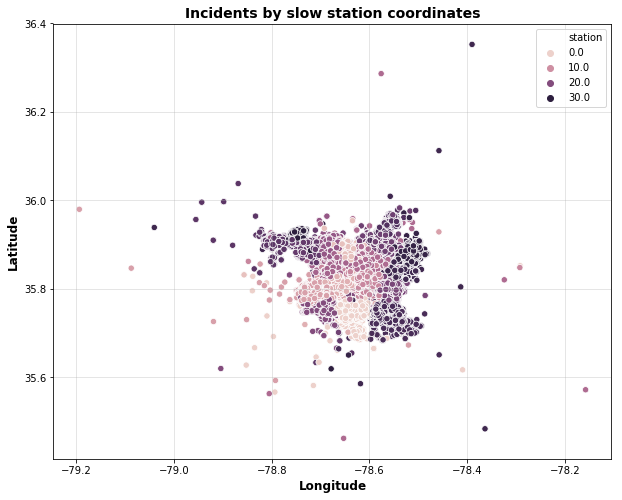

In [38]:
sns.scatterplot(data=slow_df_no, x='Longitude', y='Latitude', hue='station', legend='brief', s=40)
fig = plt.gcf()
fig.set_size_inches(10, 8)
fig.ylimit=(-60,45)
fig.xlimit=(-65,85)
plt.grid(alpha=0.4)
plt.xlabel('Longitude', fontsize=12, fontweight='bold')
plt.ylabel('Latitude', fontsize=12, fontweight='bold')
plt.title("Incidents by slow station coordinates", fontsize=14, fontweight='bold')
plt.savefig('./graphics/slow_station.png')

In [ ]:
pd.to_csv('slow_stations.csv',slow_df_no)